In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" %x)
pd.set_option("display.Width", 500)


In [3]:
data = pd.read_csv("titanic.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


<Axes: xlabel='Age'>

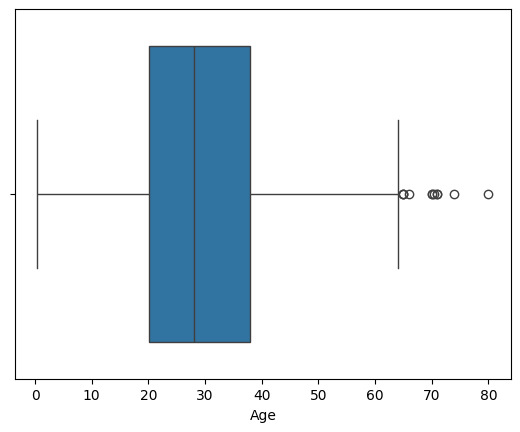

In [4]:
sns.boxplot(x = data["Age"]) # boxplot yani kutu grafik bir değişkenin dağılım bilgisini verir
# ikinci en yaygın grafik tipide histogram grafiğidir
# aşağıdaki grafikte gözüken 65> noktalar aykırı değerler
#aşağıda ıqr ın teorik bilgisi var fakat boxplot komutu aykırı değerleri otomatikmen saptar

In [5]:
# ıqr değerinin teorik hesplaması
q1 = data["Age"].quantile(0.25) # ilk çeyrek
q3 = data["Age"].quantile(0.75) # 3. çeyrek
iqr = q3 - q1
print(q1)
print(q3)
print(iqr)

print("-----------------------")
# üst limiti bulalım
upper_limit = q3 + 1.5 * iqr # ıqr hesabı için 1.5 ile çarpmak gerekir
print(upper_limit) # yani 64.8125 den sonrası aykırı değerler

print("-----------------------")
# alt sınırı bulalım
lower_limit = q1 - 1.5 * iqr
print(lower_limit) # yani -6.6875 den öncesi aykırı değerler fakat yaş - değer olamaz bu yüzden bunu görmezden gelicez

20.125
38.0
17.875
-----------------------
64.8125
-----------------------
-6.6875


In [6]:
data[(data["Age"] < lower_limit) | (data["Age"] > upper_limit)] # alt sınırdan küçük veya üst sınırdan büyük olan değerleri (aykırı değerleri)
# ekrana getirelim

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.000,0,0,C.A. 24579,10.500,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.000,0,1,113509,61.979,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.000,0,0,PC 17754,34.654,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.500,0,0,370369,7.750,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.000,0,0,336439,7.750,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.000,0,0,13509,26.550,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.000,0,0,PC 17609,49.504,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.000,0,0,27042,30.000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.000,0,0,C.A. 24580,10.500,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.000,1,1,WE/P 5735,71.000,B22,S


In [7]:
# diyelimki bana bu aykırı değere sahip kişilerin indexleri gerekecek o zaman
data[(data["Age"] < lower_limit) | (data["Age"] > upper_limit)].index # getirdi

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [8]:
# peki diyelimki aykırı değer varmı yokmu sorusu soracağım
data[(data["Age"] < lower_limit) | (data["Age"] > upper_limit)].any(axis=None) # herhangi birinde varmı sorusu sordum
#axis=0 veya 1 değil direkt tüm tüm satır ve sütunları sordum
# true çıktısı alarak aykırı değer olduğunu gördüm

np.True_

In [9]:
# programatik yapalım
def check_outliers(df, column_name):
    df[(df[column_name] < lower_limit) | (df[column_name] > upper_limit)]
    return df

# örnek çağrı
check_outliers(data, "Age").head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


bu yaptığımız işlemleri otomatikleştirelim ve fonksiyon kullanalım
böylece her seferinde aykırı değerleri her değişken için yazmaktansa bunu çağırdığımızda hemencecik getirelim

In [10]:
def outliers_thresholds(dataframe, col_name, q1=0.25, q3=0.75): #0,25 ve 0,75 genel literatür örneğidir biz 0,1 e 0,9 falanda seçebilirdik
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [11]:
outliers_thresholds(data, "Age") # artık otomatik


(np.float64(-6.6875), np.float64(64.8125))

In [12]:
# aykırı değerleri silerken bunu da fonksiyon olarak yazalım
def drop_outliers(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outliers_thresholds(dataframe, col_name, q1, q3)
    dataframe.drop(dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].index, inplace=True)
drop_outliers(data, "Age")
data.head()

# gibi gibi çeşitli fonksiyonlarla programlanabilirlik önemli

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


# ----------------------------------------------------------------
## ders_2
# ----------------------------------------------------------------


In [13]:
data_titanic = pd.read_csv("titanic.csv")
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.458,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000,0,0,17463,51.862,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000,3,1,349909,21.075,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000,0,2,347742,11.133,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000,1,0,237736,30.071,NaN,C


burda sorun var şimdi sütunlara baktığımızda anlıyoruz
outliers biri sayısal biri kategorik değişken veya sayısal görünümlü kategorik, kategorik görünümlü sayısal değişken gibi veya birton farklı
problem ortaya çıkar
bunları programatik yapmak istersem ne yapmalıyım?


In [14]:
def grab_col_names(dataframe, cat_th=10, car_th=20): # her türden aykırı değeri programatik bir şekilde tespit eden fonksiyonu yazıcaz
    # cat_th anlamı şu = eğer 10 dan az farklı tipte değişken var ise bu benim için kategoriktir diyorum
    #cat_th ve car_th benim keyfime göre 10 ve 20 belirledim
    """
    veri setindeki kategorik , numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir
    NOT: kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir (0 or 1 gibi)
    Parameters
    -----------------
    dataframe : dataframe
            değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
            numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
            kategorik fakat kardinal değişkenler için sınıf eşik değeri
    RETURNS:
    ------------------
        cat_cols: list
            kategorik değişken listesi
        num_cols: list
            numerik değişken listesi
    """

    # kategorik sütunlar
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    # numerik gözüken ama kategorik olan sütunlar
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    # nunique ile kaç tane eşsiz değer var    eğer cat_th yani 10 dan az ise bu kategoriktir ve

    # kategorik fakat kardinal değişkenlerdeki sütunlar (0 veya 1 gibi)
    cat_but_car_cols = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    # buda kategorik gibi gözüken ama car_th yani 20 den fazla çeşitteki kategorik değişken varsa bu kategorik değildir
    # mesela a,b,c,d,e,f,...u,ü,v. olsun kategorik gibi gözüküyor ama 20 den fazla yani kardinal olduğundan sen kategorik değilsin diyom

    cat_cols = cat_cols + num_but_cat


    cat_cols = [col for col in cat_cols if col not in cat_but_car_cols]

    # numerik olanlar
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"gözlem: {dataframe.shape[0]}")
    print(f"değişkenler: {dataframe.shape[1]}")
    print(f"categorical columns: {len(cat_cols)}")
    print(f"numeric columns: {len(num_cols)}")
    print(f"cat but car cols: {len(cat_but_car_cols)}")
    print(f"num but cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car_cols

grab_col_names(data_titanic)

gözlem: 891
değişkenler: 12
categorical columns: 6
numeric columns: 3
cat but car cols: 3
num but cat: 4


(['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch'],
 ['PassengerId', 'Age', 'Fare'],
 ['Name', 'Ticket', 'Cabin'])

# ----------------------------------------------------------------
## ders_3
# ----------------------------------------------------------------


In [15]:
# bu kısımlar ders_1 de yazdığımız kodlardan geldi bunun üzerinden devam edicez

# ıqr değerinin teorik hesplaması
q1 = data["Age"].quantile(0.25) # ilk çeyrek
q3 = data["Age"].quantile(0.75) # 3. çeyrek
iqr = q3 - q1
print(q1)
print(q3)
print(iqr)

print("-----------------------")
# üst limiti bulalım
upper_limit = q3 + 1.5 * iqr # ıqr hesabı için 1.5 ile çarpmak gerekir
print(upper_limit) # yani 64.8125 den sonrası aykırı değerler

print("-----------------------")
# alt sınırı bulalım
lower_limit = q1 - 1.5 * iqr
print(lower_limit) # yani -6.6875 den öncesi aykırı değerler fakat yaş - değer olamaz bu yüzden bunu görmezden gelicez


def outliers_thresholds(dataframe, col_name, q1=0.25, q3=0.75): #0,25 ve 0,75 genel literatür örneğidir biz 0,1 e 0,9 falanda seçebilirdik
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


data[(data["Age"] < lower_limit) | (data["Age"] > upper_limit)]
data[(data["Age"] < lower_limit) | (data["Age"] > upper_limit)].index

# bunları her seferinde tekrar tekrar yapacağımıza (yani age değilde başka bir değişken yazmaya kalkarsan tekrar aynı şeyleri yazmayalım)
# fonksiyonel yaparız

20.0
38.0
18.0
-----------------------
65.0
-----------------------
-7.0


Index([], dtype='int64')

In [16]:
def grab_outliers(dataframe, col_name, index=False):   # aykırı değer yakalayıcı
    low, up = outliers_thresholds(dataframe, col_name) 
    if dataframe[((dataframe[col_name] < lower_limit) | (dataframe[col_name] > upper_limit))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < lower_limit) | (dataframe[col_name] > upper_limit))].head())
    else:
        print(dataframe[((dataframe[col_name] < lower_limit) | (dataframe[col_name] > upper_limit))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < lower_limit) | (dataframe[col_name] > upper_limit))]
        return outlier_index
    

grab_outliers(data, "Age")


Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


In [17]:
def remove_outliers(dataframe, col_name): # aykırı değerleri kaldırıyoruz
    low_limit, up_limit = outliers_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))] # aykırılar hariç yeni df e ata
    return df_without_outliers

remove_outliers(data, "Age").head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [18]:
num_cols = [col for col in num_cols if col not in "PassangerId"] # burda niye çalışmadı anlamadım

for col in num_cols:
    new_df_titanic = remove_outliers(data_titanic, col)

data_titanic - new_df_titanic.shape # amaç burada yeni data ile eski datadaki satırları çıkartıp kaç satır kaldığını görmekti


NameError: name 'num_cols' is not defined

## aykırı değerleri baskılama yöntemi


In [70]:
# bu kısımlar ders_1 de yazdığımız kodlardan geldi bunun üzerinden devam edicez

# ıqr değerinin teorik hesplaması
q1 = data_titanic["Age"].quantile(0.25) # ilk çeyrek
q3 = data_titanic["Age"].quantile(0.75) # 3. çeyrek
iqr = q3 - q1

upper_limit = q3 + 1.5 * iqr
print(upper_limit) 

# yani önceki yaptığımız kodlar

data_titanic.loc[data_titanic["Fare"] > upper_limit] = upper_limit
# baskılama için 64 üstü olan aykırı değerleri 64 e sabitleriz
data_titanic["Fare"].head()



88.5


0    7.250
1   64.812
2    7.925
3   53.100
4    8.050
Name: Fare, dtype: float64

# ----------------------------------------------------------------
## ders_4 çok değişkenli aykırı değer işlemleri
# ----------------------------------------------------------------


Local Outlier Factor (lof)
çok değişkenli outlier değer yakalama yöntemidir en yakın kımşularından uzak olan değerler otlier değer
en yakın komşuları harbidende yakınsa ozaman inlayer değerki 1 e en yakın olması inlayer
1 den uzaklaşması mesela 6,7,8 belirlediğin sayı sonrası outlier değerdir
grafiklere bak daha iyi anlaşılıyor

In [84]:
df = sns.load_dataset("diamonds") #diamonds u getir
df = df.select_dtypes(include=["float64", "int64"]) # sadece sayısal değişkenleri getir
df = df.dropna() # eksik değerleride kaldır

lower_limit, upper_limit = outliers_thresholds(df, "carat")
df[(df["carat"] < lower_limit) | (df["carat"] > upper_limit)].shape # 1889 tane aykırı değeri varmış



(1889, 7)

In [85]:
lower_limit, upper_limit = outliers_thresholds(df, "depth")
df[(df["depth"] < lower_limit) | (df["depth"] > upper_limit)].shape # 2545 tane aykrısı varmış

(2545, 7)

In [86]:
# çok yüksek sayıda outlier değer geliyor
# en üstte import ettiğimiz localoutlier modelini getirelim

clf = LocalOutlierFactor(n_neighbors=20) # burada lofu hazırladık
clf.fit_predict(df) # df in her hücresi için hesaplamalarını yaptırdık yani öz hazırlık matematik işlemleri

array([-1, -1, -1, ...,  1,  1,  1], shape=(53940,))

In [88]:
df_scores = clf.negative_outlier_factor_ # şimdide df skorlarımızı bu bölüm yapıyor
df_scores[0:15] # mesela ilk 15 tanesinin nof değerini buradan görüyoruz
# değerler eksi gözüküyor istersen pozitifede çevirebilirsin ama ileride okurken daha çok işe yarayacak
# -1 e yaklaştıkça aykırılık düşer 

array([-1.58352526, -1.59732899, -1.62278873, -1.33002541, -1.30712521,
       -1.28408436, -1.28428162, -1.26458706, -1.28422952, -1.27351342,
       -1.23611906, -1.20830179, -1.17637026, -1.13060731, -1.14305176])

In [92]:
# en aykırı değerleri büyükten küçüğe sıralayalım mesela
np.sort(df_scores)[0:10]

array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092,
       -4.81502092, -4.61522833, -4.37081214, -4.29842288, -4.10492387])

<function matplotlib.pyplot.show(close=None, block=None)>

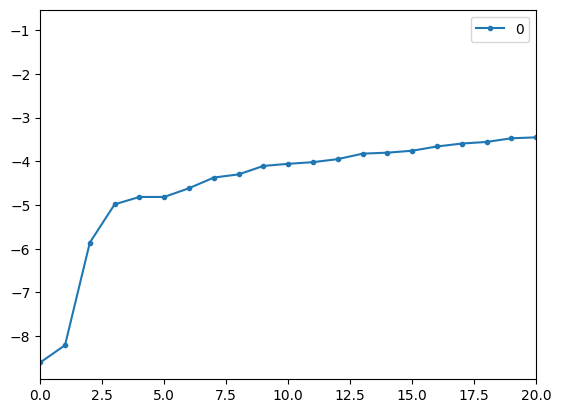

In [93]:
# grafikle görelim
scores = pd.DataFrame(np.sort(df_scores)) # tüm değerleri score a atadım
scores.plot(stacked=True, xlim=[0, 20], style=".-") # grafifi oluşturdum
plt.show


# neyi eşik değer olarak seçmeliyim bu grafiğe bakıp belirlemeliyim
# grafikteki en marjinal değişim 2.5 ile 5 arasında olmuş demekki burayı eşik değer belirlersem az sayıda değişkenimi datasetten çıkartırım
# vede -8 -7 -6 gibi ml yi sapıtacak değerlerdende kurtulurum özetle en optimum noktayı grafiği yorumlayarak anlarım


<function matplotlib.pyplot.show(close=None, block=None)>

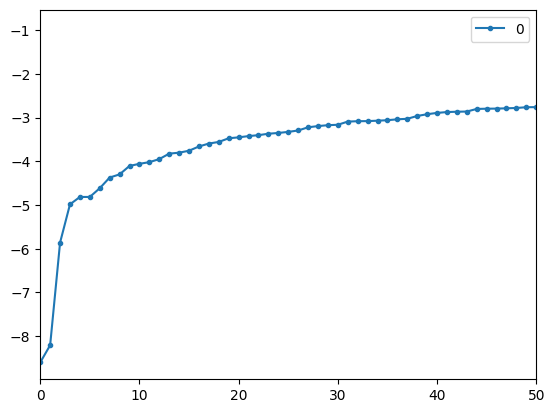

In [94]:
# grafikle görelim
scores = pd.DataFrame(np.sort(df_scores)) 
scores.plot(stacked=True, xlim=[0, 50], style=".-") # mesela sondan 20 değilde 50 tanesini gözlemleyelim
plt.show
# buna bakarak 10 u eşik değer belirlemelimiyim sorusu gelebilir gibi gibi

In [172]:
# mesela eşik değerimi 3 olarak belirleyeyim
th = np.sort(df_scores)[3] # 3. sıradakinin değeri neymiş bakalım
th # -4.984151747711709 imiş

np.float64(-4.984151747711709)

In [173]:
df[df_scores < th] # -4.984151747711709 değerinden küçük olanları aykırı değer olarak alacağım için bir bakış atayım
# tek başına baktığımızda birsürü aykırı değer varken çok değişkenli baktığımızda çok az aykırı değer olduğunu gördük
# sebebini aşağıda gözlemleyelim

,carat,depth,table,price,x,y,z
41918,1.030,78.200,54.000,1262,5.720,5.590,4.420
48410,0.510,61.800,54.700,1970,5.120,5.150,31.800
49189,0.510,61.800,55.000,2075,5.150,31.800,5.120


In [175]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

# mesela göze çarpanlara bakalım
# 41918.satır depth değeri 78.200 ama aşağıdaki tabloda bizim max değerimiz 79.000 yani bu diğer değerlerle birleşince dışarıda kalmış
# veya 48410. satır tüm değerler normal gözükürken z değeri onu grafiğin dışına atmış ortalama z 3.5 iken
# bizim aykırıdaki z değeri 31.8 imiş

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
carat,53940.000,0.798,0.474,0.200,0.240,0.300,0.700,1.040,1.510,2.180,5.010
depth,53940.000,61.749,1.433,43.000,57.900,59.300,61.800,62.500,63.300,65.600,79.000
table,53940.000,57.457,2.234,43.000,53.000,54.000,57.000,59.000,60.000,64.000,95.000
price,53940.000,3932.800,3989.440,326.000,429.000,544.000,2401.000,5324.250,9821.000,17378.220,18823.000
x,53940.000,5.731,1.122,0.000,4.020,4.290,5.700,6.540,7.310,8.360,10.740
y,53940.000,5.735,1.142,0.000,4.040,4.300,5.710,6.540,7.300,8.340,58.900
z,53940.000,3.539,0.706,0.000,2.480,2.650,3.530,4.040,4.520,5.150,31.800


özetle lof için birçok karar verme yöntemi varda mesela benim elimde 500 satırlık veriseti varsa ve algoritma etkileniyorsa
az sayıda aykırı varsa sil gitsin örnek 500 satırda 5 satır aykırı varsa sil gitsin
ama 50 satır aykırı değer varsa silme lof kullan gibi stratejiler izle

eğer ağaç yöntemleri ml de kullanılıyorsa genelde aykırı değerler silinmez ha illa silineceksede mesela iqr1 0.01 iqr3 0.99 al en uç noktalardan çıkart